In [95]:
from PIL import Image

from six.moves import range

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import keras
from keras import backend as bkend
from keras.datasets import cifar10, mnist
from keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import metrics
from keras.models import Model
from keras.utils.generic_utils import Progbar

import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt

from plotnine import *
import plotnine

import math
import inspect

import tensorflow

from six.moves import range

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score

from scipy.stats import norm

import keras
from keras import backend as bkend
from keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling, Reshape, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import metrics
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.utils.generic_utils import Progbar
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.python.client import device_lib

get_ipython().magic("matplotlib inline")

os.environ["KERAS_BACKEND"] = "tensorflow"
importlib.reload(bkend)

<module 'keras.backend' from '/Users/sedatkilic/anaconda3/lib/python3.7/site-packages/keras/backend/__init__.py'>

In [96]:
mnist = mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1], x_train.shape[2], 1])
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1], x_test.shape[2], 1])
y_train = y_train.ravel()
y_test = y_test.ravel()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255.0
x_test /= 255.0

scaler_classifier = MinMaxScaler(feature_range=(0.0, 1.0))
logistic = linear_model.LogisticRegression(random_state=666, verbose=1)
lb = LabelBinarizer()
lb = lb.fit(y_train.reshape(y_train.shape[0], 1))

In [99]:



class DeepConvGenAdvNet(BaseEstimator, 
                        TransformerMixin):
    def __init__(self, 
                 z_size=None,
                 iterations=None,
                 batch_size=None):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
        
        # Build the discriminator.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer=RMSprop(lr=0.0002, 
                                                     clipvalue=1.0,
                                                     decay=1e-8),
                                   loss="binary_crossentropy")

        # Build the generator to fool the discriminator.
        # Freeze the discriminator here.
        self.discriminator.trainable = False
        self.generator = self.build_generator()
        GAN_input = Input(shape=(self.z_size,))
        GAN_fake = self.generator(GAN_input)
        GAN_output = self.discriminator(GAN_fake)

        # Build the GAN.
        self.GAN = Model(GAN_input, GAN_output)
        self.GAN.compile(optimizer=RMSprop(lr=0.0004, 
                                           clipvalue=1.0,
                                           decay=1e-8),
                         loss="binary_crossentropy")
 
    def fit(self, X, y=None):
        num_train = X.shape[0]
        start = 0
        
        for step in range(self.iterations):
            # Generate a new batch of noise...
            noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, self.z_size))
            # ...and generate a batch of fake images.
            generated_images = self.generator.predict(noise)
            
            stop = start + self.batch_size
            # Get a batch of real images.
            image_batch = X[start:stop]

            # [real, fake].
            x = np.concatenate((image_batch, generated_images))
            # [real, fake].
            y = np.concatenate([np.ones(shape=(self.batch_size, 1)), np.zeros(shape=(self.batch_size, 1))])
            y += 0.05 * np.random.random(size=y.shape)

            # See if the discriminator can figure itself out.
            self.d_loss = self.discriminator.train_on_batch(x, y)

            # Make new noise.
            noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, self.z_size))

            # We want to train the generator to trick the discriminator.
            # For the generator, we want all the [real, fake] labels to say real.
            trick = np.ones(shape=(self.batch_size, 1))

            self.gan_loss = self.GAN.train_on_batch(noise, trick)
                
            start += self.batch_size
            if start > num_train - self.batch_size:
                start = 0
            
            if step % 100 == 0:
                print("Step:", step)
                print("Discriminator loss:", self.d_loss)
                print("GAN loss:", self.gan_loss)
                
                #img = image.array_to_img(generated_images[0] * 255.0, scale=False)
                #img.save("outputs/generated_image" + str(step) + ".png")
                
                #img = image.array_to_img(image_batch[0] * 255.0, scale=False)
                #img.save("outputs/real_image" + str(step) + ".png")

        return self

    def transform(self,
                  X):
        return self.feature_extractor.predict(X)

    def build_generator(self):
        # We will map z, a latent vector, to image space (..., 28, 28, 1).
        latent = Input(shape=(self.z_size,))

        # This produces a (..., 7, 7, 128) shaped tensor.
        cnn = Dense(units=1024, activation="tanh")(latent)
        cnn = Dense(units=128 * 7 * 7, activation="tanh")(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Reshape((7, 7, 128))(cnn)

        # Upsample to (..., 14, 14, 64).
        cnn = layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="tanh")(cnn)
        cnn = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="tanh")(cnn)

        # Upsample to (..., 28, 28, 64).
        cnn = layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="tanh")(cnn)

        # Take a channel axis reduction to (..., 28, 28, 1).
        fake_img = Conv2D(filters=1, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="sigmoid", kernel_initializer="glorot_normal", name="generator")(cnn)

        return Model(latent, fake_img)
    
    def build_discriminator(self):
        image = Input(shape=(28, 28, 1))

        cnn = Conv2D(filters=64, kernel_size=(5, 5), padding="same", strides=(2, 2), activation="tanh")(image)
        cnn = layers.MaxPooling2D(pool_size=(2, 2))(cnn)
        cnn = Conv2D(filters=128, kernel_size=(5, 5), padding="same", strides=(2, 2), activation="tanh")(cnn)
        cnn = layers.MaxPooling2D(pool_size=(2, 2))(cnn)
        cnn = Flatten()(cnn)
        cnn = Dense(units=1024, activation="tanh")(cnn)
        self.feature_extractor = Model(image, cnn)

        is_real_img = Dense(units=10, activation="sigmoid", name="discriminator")(cnn)     
        
        return Model(image, is_real_img)
            
    def evaluate(self,
                 X):
        num_test = X.shape[0]

        # Generate a new batch of noise.
        noise = np.random.uniform(low=-1.0, high=1.0, size=(num_test, self.z_size))
        generated_images = self.generator.predict(noise)

        # [real, fake].
        x = np.concatenate((X, generated_images))
        # [real, fake].
        y = np.concatenate([np.ones(shape=(num_test, 1)), np.zeros(shape=(num_test, 1))])
        y += 0.05 * np.random.random(size=y.shape)

        self.d_test_loss = self.discriminator.evaluate(x, y)

        # Make new noise.
        noise = np.random.uniform(low=-1.0, high=1.0, size=(num_test, self.z_size))
        trick = np.ones(shape=(num_test, 1))

        self.gan_test_loss = self.GAN.evaluate(noise, trick)
        
        return [self.d_test_loss, self.gan_test_loss]

/Users/sedatkilic/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 0
Discriminator loss: 0.6987603
GAN loss: 1.1505722


/Users/sedatkilic/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 100
Discriminator loss: 0.15943646
GAN loss: 0.51522326
Step: 200
Discriminator loss: 0.8353911
GAN loss: 0.60314524
Step: 300
Discriminator loss: 0.06759806
GAN loss: 0.03335538
Step: 400
Discriminator loss: 0.20106992
GAN loss: 0.041303016
Step: 500
Discriminator loss: 0.28627422
GAN loss: 0.10132126
Step: 600
Discriminator loss: 0.5155313
GAN loss: 1.5196339
Step: 700
Discriminator loss: 0.4588183
GAN loss: 0.44816524
Step: 800
Discriminator loss: 0.2510046
GAN loss: 0.38071662
Step: 900
Discriminator loss: 0.37469918
GAN loss: 0.663804
Step: 1000
Discriminator loss: 0.2136217
GAN loss: 0.24029806
Step: 1100
Discriminator loss: 0.17105792
GAN loss: 0.1624967
Step: 1200
Discriminator loss: 0.47418854
GAN loss: 0.35695916
Step: 1300
Discriminator loss: 0.23250581
GAN loss: 0.23706584
Step: 1400
Discriminator loss: 0.317733
GAN loss: 1.3342153
Step: 1500
Discriminator loss: 0.32212043
GAN loss: 0.3045584
Step: 1600
Discriminator loss: 0.3971206
GAN loss: 0.9088327
Step: 1700
Disc

/Users/sedatkilic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sedatkilic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[LibLinear]The accuracy score for the MNIST classification task with DCGAN: 98.240000%.


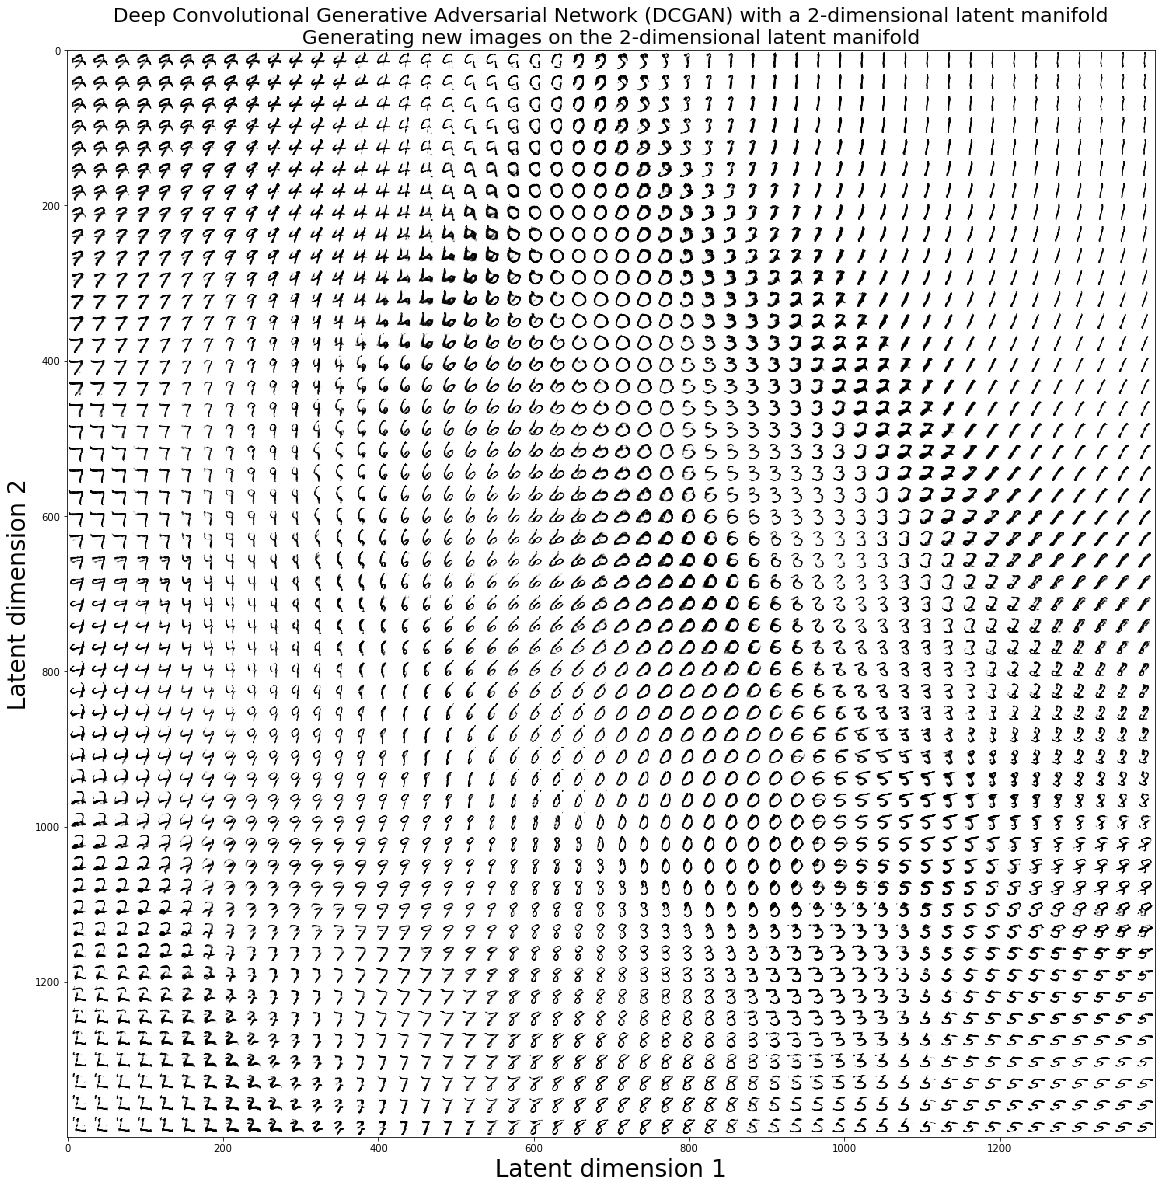

In [100]:
dcgan = DeepConvGenAdvNet(batch_size=100,
                          iterations=10000,
                          z_size=2)

pipe_dcgan = Pipeline(steps=[("DCGAN", dcgan),
                             ("scaler_classifier", scaler_classifier),
                             ("classifier", logistic)])
pipe_dcgan = pipe_dcgan.fit(x_train, y_train)

acc_dcgan = pipe_dcgan.score(x_test, y_test)

print("The accuracy score for the MNIST classification task with DCGAN: %.6f%%." % (acc_dcgan * 100))

In [ ]:
dcGANLoss = dcgan.fit(x_train, y_train)

/Users/sedatkilic/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 0
Discriminator loss: 0.67397034
GAN loss: 0.66344905
Step: 100
Discriminator loss: 0.6790398
GAN loss: 0.826398
Step: 200
Discriminator loss: 0.6036938
GAN loss: 0.67924476
Step: 300
Discriminator loss: 0.6407057
GAN loss: 0.7652629
Step: 400
Discriminator loss: 0.7036764
GAN loss: 0.75575995
Step: 500
Discriminator loss: 0.664541
GAN loss: 0.7231419
Step: 600
Discriminator loss: 0.72749114
GAN loss: 0.59076524
Step: 700
Discriminator loss: 0.66191804
GAN loss: 0.8267132
Step: 800
Discriminator loss: 0.60761744
GAN loss: 0.9616881
Step: 900
Discriminator loss: 0.6510944
GAN loss: 0.716152
Step: 1000
Discriminator loss: 0.65839326
GAN loss: 0.7131539
Step: 1100
Discriminator loss: 0.64039975
GAN loss: 0.74227804
Step: 1200
Discriminator loss: 0.7041504
GAN loss: 0.70136714
Step: 1300
Discriminator loss: 0.68818605
GAN loss: 0.73742807
Step: 1400
Discriminator loss: 0.592542
GAN loss: 1.0525726
Step: 1500
Discriminator loss: 0.62351733
GAN loss: 0.72701854
Step: 1600
Discriminator

In [ ]:
accdcgan = dcgan.score(x_test, y_test)